# Plotting Your Data
----
To start out, you'll want to load your data from a file using numpy.  Make sure you also get the angle step right here, or else things could turn out really strange.

In [1]:
import numpy as np
data_filename = "2_source.csv"
using_colab = False
    # Change to True if you are running Juptyer via Colab

In [2]:
if using_colab:
    from google.colab import files
    uploaded = files.upload()
    data_filename = next(iter(uploaded.keys()))
    # This last line is a trick that will automatically pull the filename from what you uploaded.

In [3]:
data = np.loadtxt(data_filename,delimiter=",")   
angles = []
angle_step = 15
for i in range(len(data)):
    angles.append(i*angle_step)
print(angles)

[0, 15, 30, 45, 60, 75, 90]


Now that that's loaded, we'll us matplotlib's `imshow` command to display our data as a 2d image with intensity coded as color.  

`extent` here is used to define the `x` and `y` axis start and end values

`aspect="auto"` makes the plot square instead of long & thin.

<IPython.core.display.Javascript object>


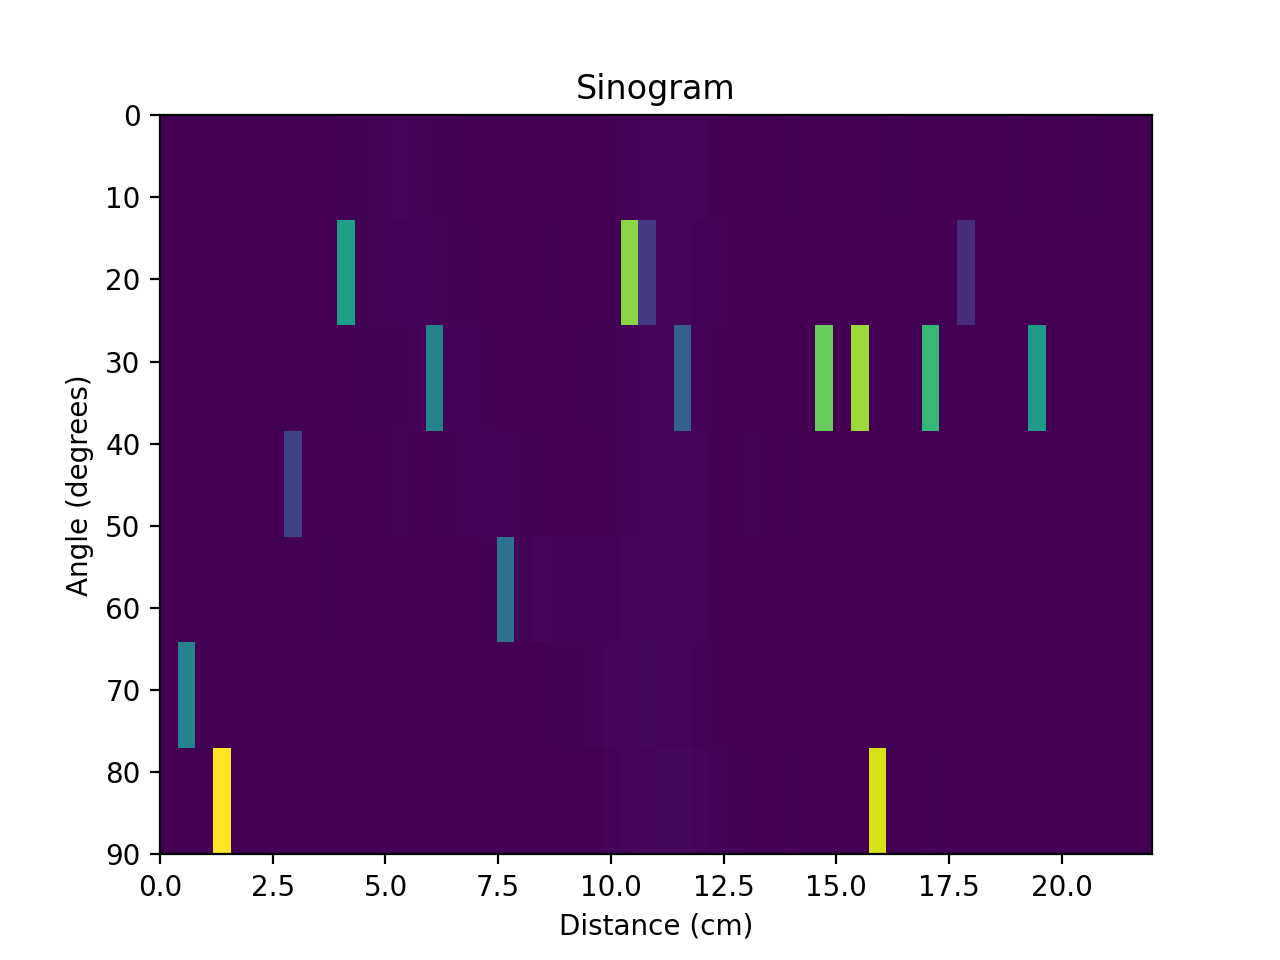

In [4]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig,ax = plt.subplots()
start_dist = 0
end_dist = 22
start_angle = 0
end_angle = angles[-1]  # This is the last angle in the array, no matter how many angles are in it.
ax.imshow(data,extent=[start_dist,end_dist,end_angle,start_angle],aspect="auto")
ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Angle (degrees)")
ax.set_title("Sinogram");

Now we have an inverse problem:  We know what the intensity of our source looks like as a function of distance and angle, but we want to know it in terms of x and y position.

There are a number of ways we can go about doing this, but we'll start with the simplest first: projecting out our slices along the line of response for the detectors, rotating these projections by their associated angles, and then combining all these together to get a composite plot.

To project out out slices, we'll use `np.outer` to do an outer product; this turns our 1d slices into 2d matricies.

The doce below does this for each slice in our data, and plots the results for the first and second slices.

<IPython.core.display.Javascript object>


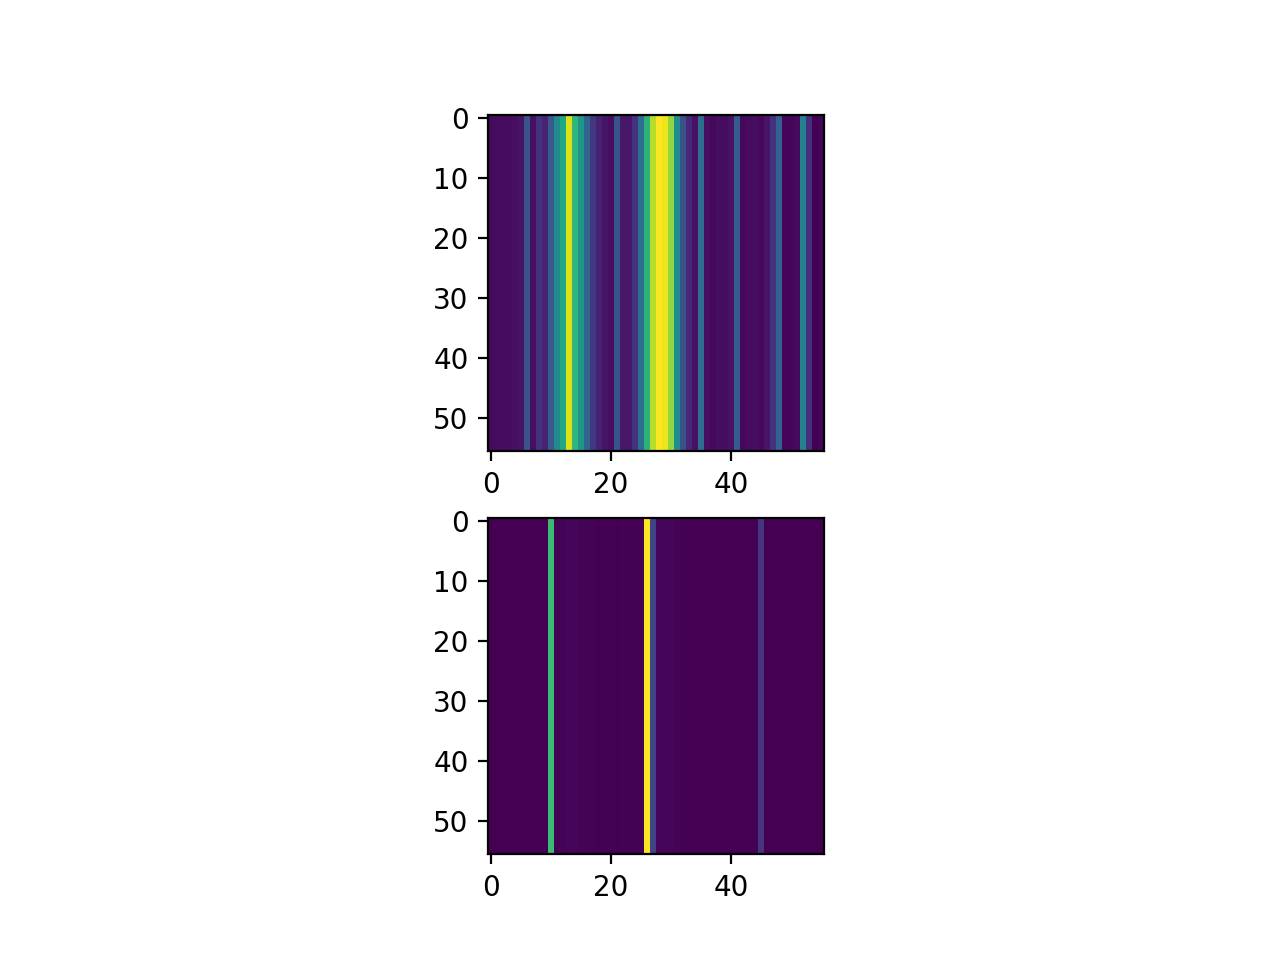

In [5]:
from scipy import ndimage
expand_vec = np.ones(data[0].size)  # this is used to get us a square matrix
expanded_data = []
for item in data:
    expanded_data.append(np.outer(expand_vec,item))
    
fig, (ax,ay) = plt.subplots(2)
ax.imshow(expanded_data[0])
ay.imshow(expanded_data[1])

Okay, we've made 2d representations of our data.  Now how do we rotate them?  Instead of writing code to do matrix rotation ourselves, we'll use scipy's `ndimage` library.  Unless you manually want to write a matrix rotation algorithm.  I'm not your boss, knock yourself out.

<IPython.core.display.Javascript object>


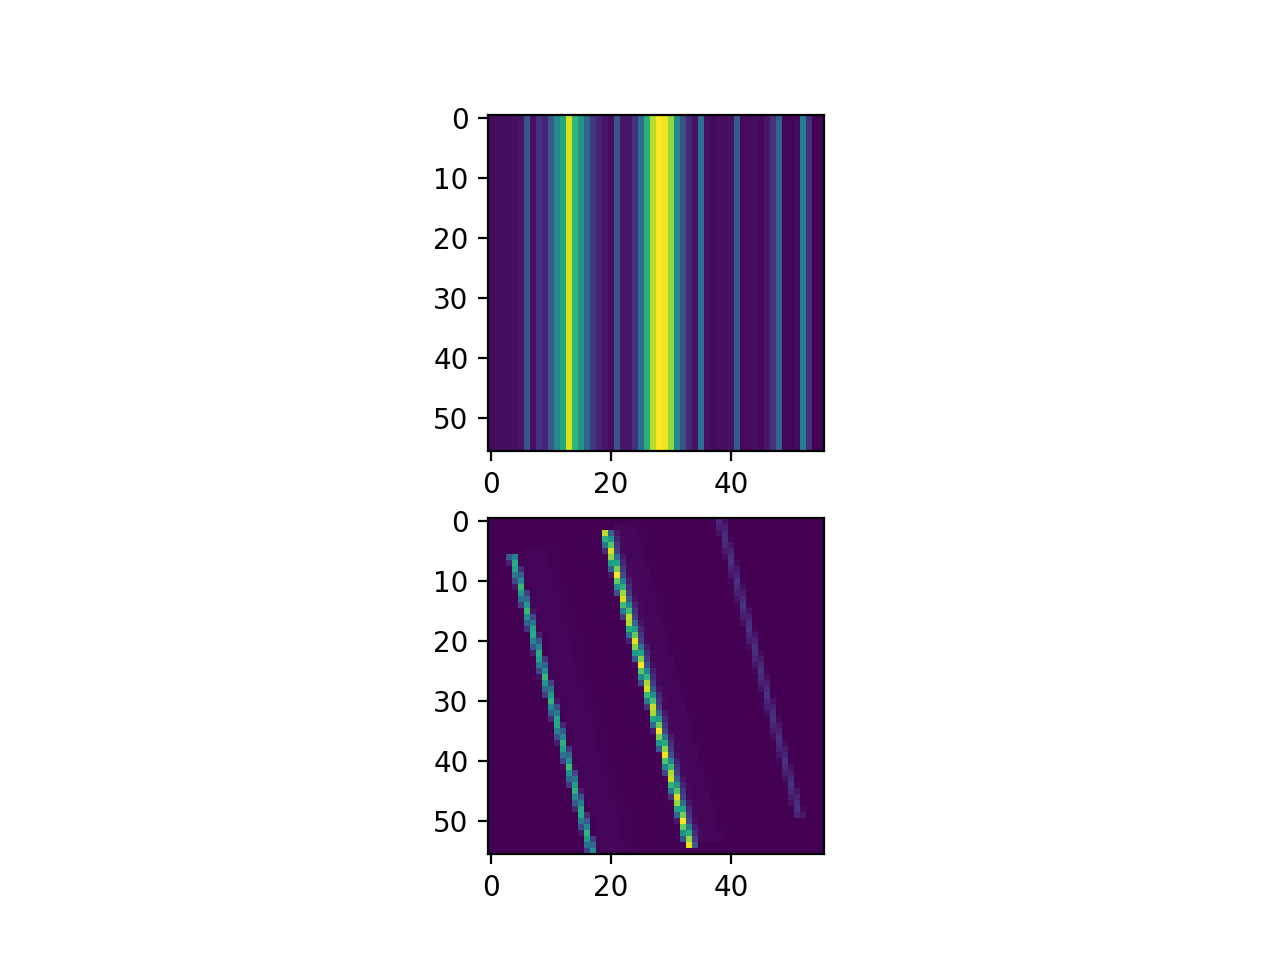

In [6]:
rotated_data = []
for index, item in enumerate(expanded_data):
    rotated_data.append(ndimage.rotate(item,angles[index],reshape=False,order=1)) # we want Numpy to keep our square, 2d matricies.
    
fig, (ax,ay) = plt.subplots(2)
ax.imshow(rotated_data[0])
ay.imshow(rotated_data[1])    

The rotated part has some bad aliasing going on, but it more-or-less captures the results of our third scan.  We'll show how to reduce that a bit later, but for now let's start recombining data!

To do this, we'll make a composite image by multiplying each of these expanded & rotated slices together.  Locations where we don't see many coincidences at any angle will end up with low counts, and locations with lots of coincidences at similar angles will end up with high counts.  It may be easier to see what this looks like, so let's start by recombining just the first and third slices.

We'll also normalize the data by taking the `nth` root, where `n` is the number of slices we're using.  The units would end up being something insane if we didn't do this.

<IPython.core.display.Javascript object>


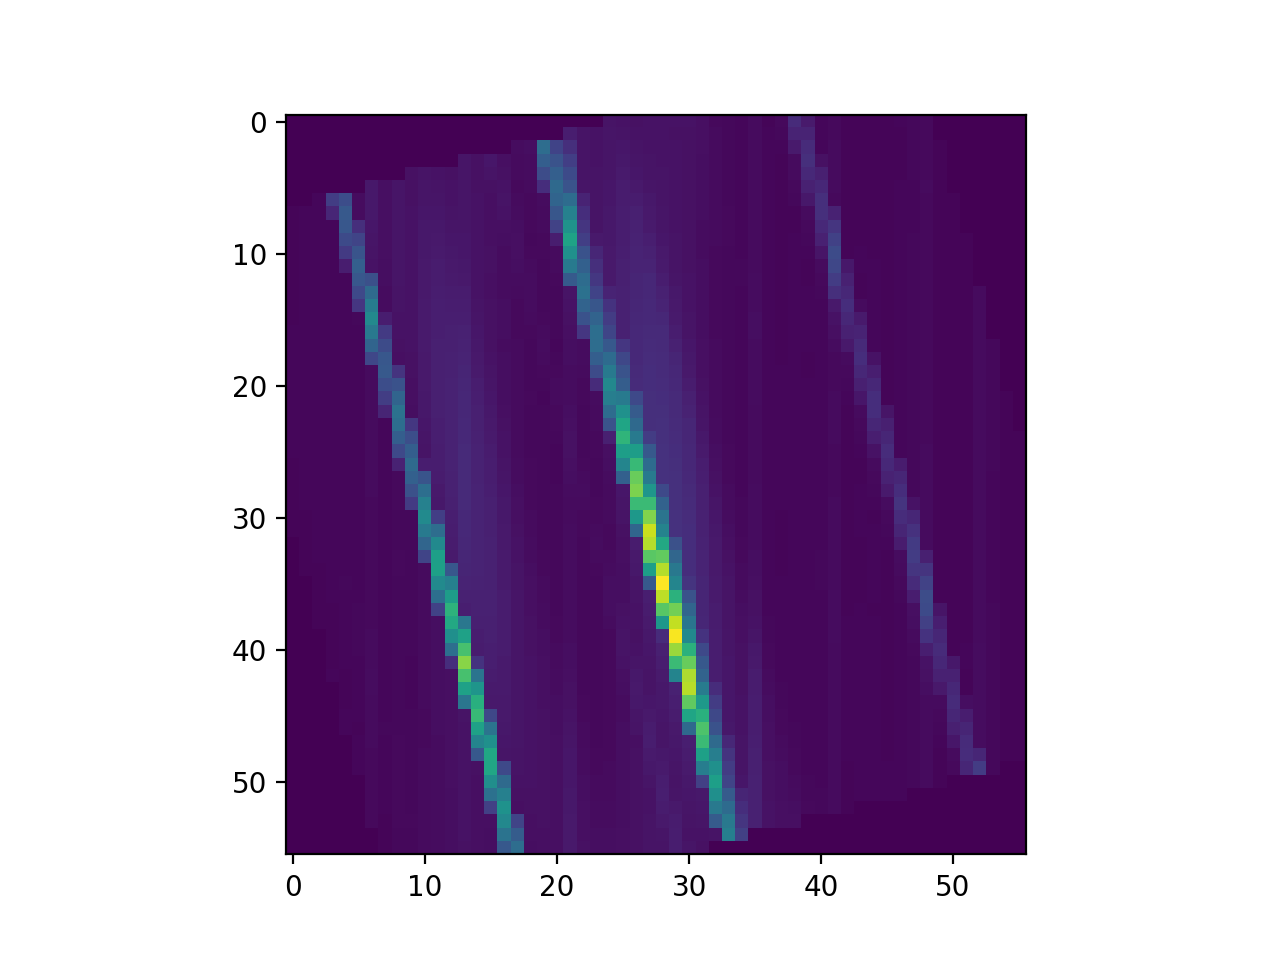

In [7]:
composite = rotated_data[0] * rotated_data[1]
normalized = np.power(composite,(1/2))

fig, ax = plt.subplots()
ax.imshow(normalized)

You should now have some smears or blobs in your image instead of just straight lines.  Let's go ahead and go through the entire thing and see what we get.

<IPython.core.display.Javascript object>


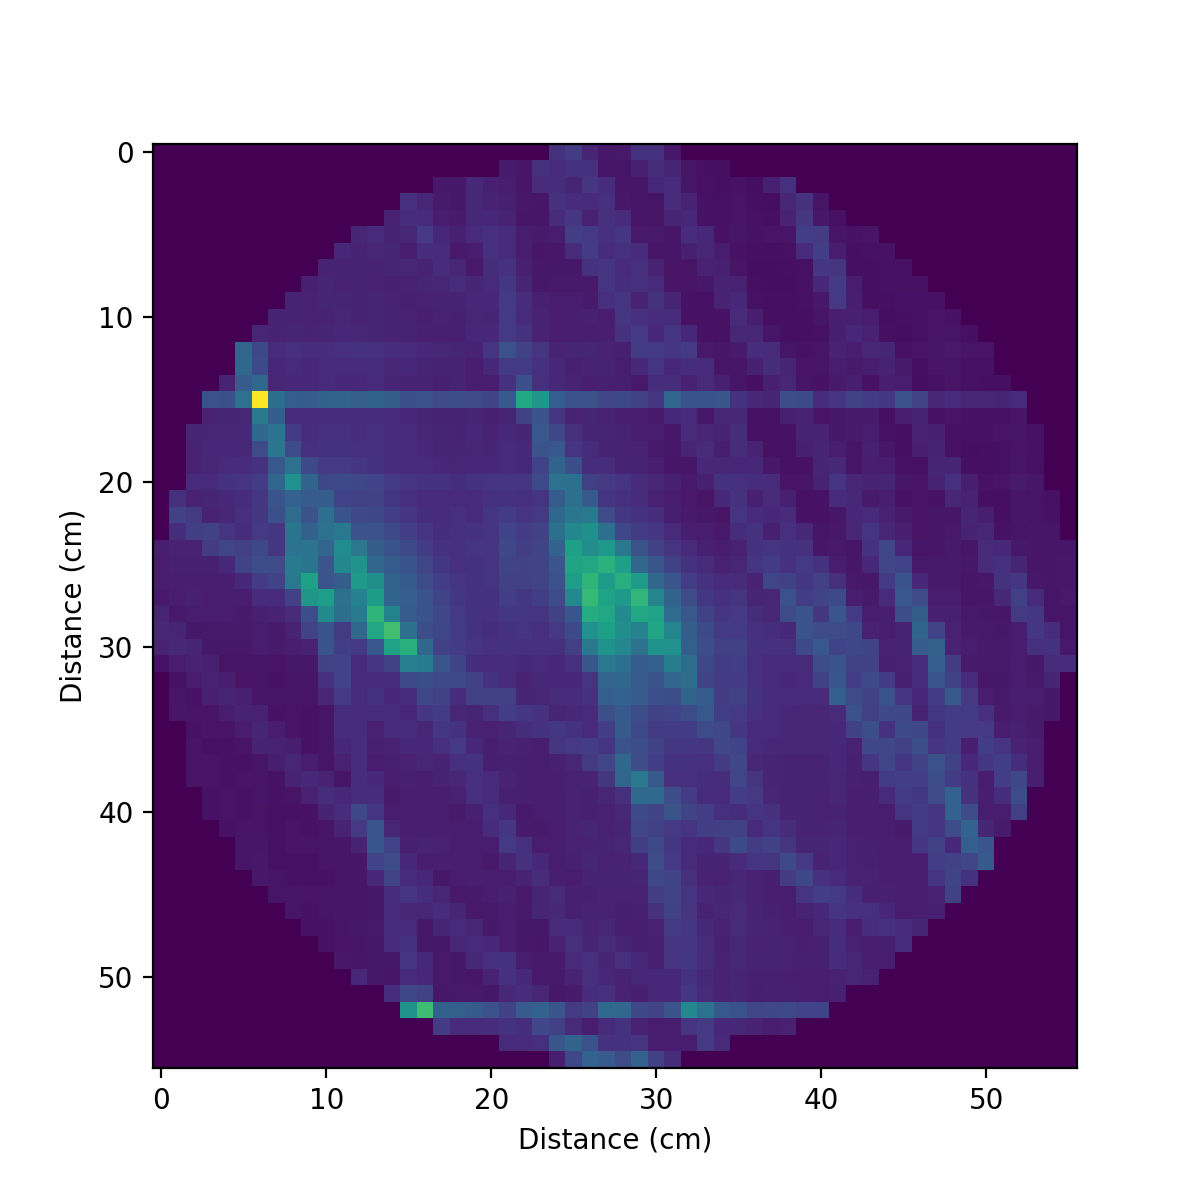

In [11]:
composite = np.ones_like(rotated_data[0]) # We need a matrix full of 1s to start out with, we can't multiply an empty matrix with anything.
for item in rotated_data:
    composite *= item
normalized = np.power(composite,(1/len(rotated_data))) #

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(normalized)
ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Distance (cm)")

fig.savefig('2source-sinogram-unfiltered.png')

While likely quite blurry, you should have something that now at least vaguely resembles a few point sources.  Congratulations, you've now got the basics down!

# Alternate Plot Types
----
We can also make contour plots, showing regions of equal intensity.

<IPython.core.display.Javascript object>


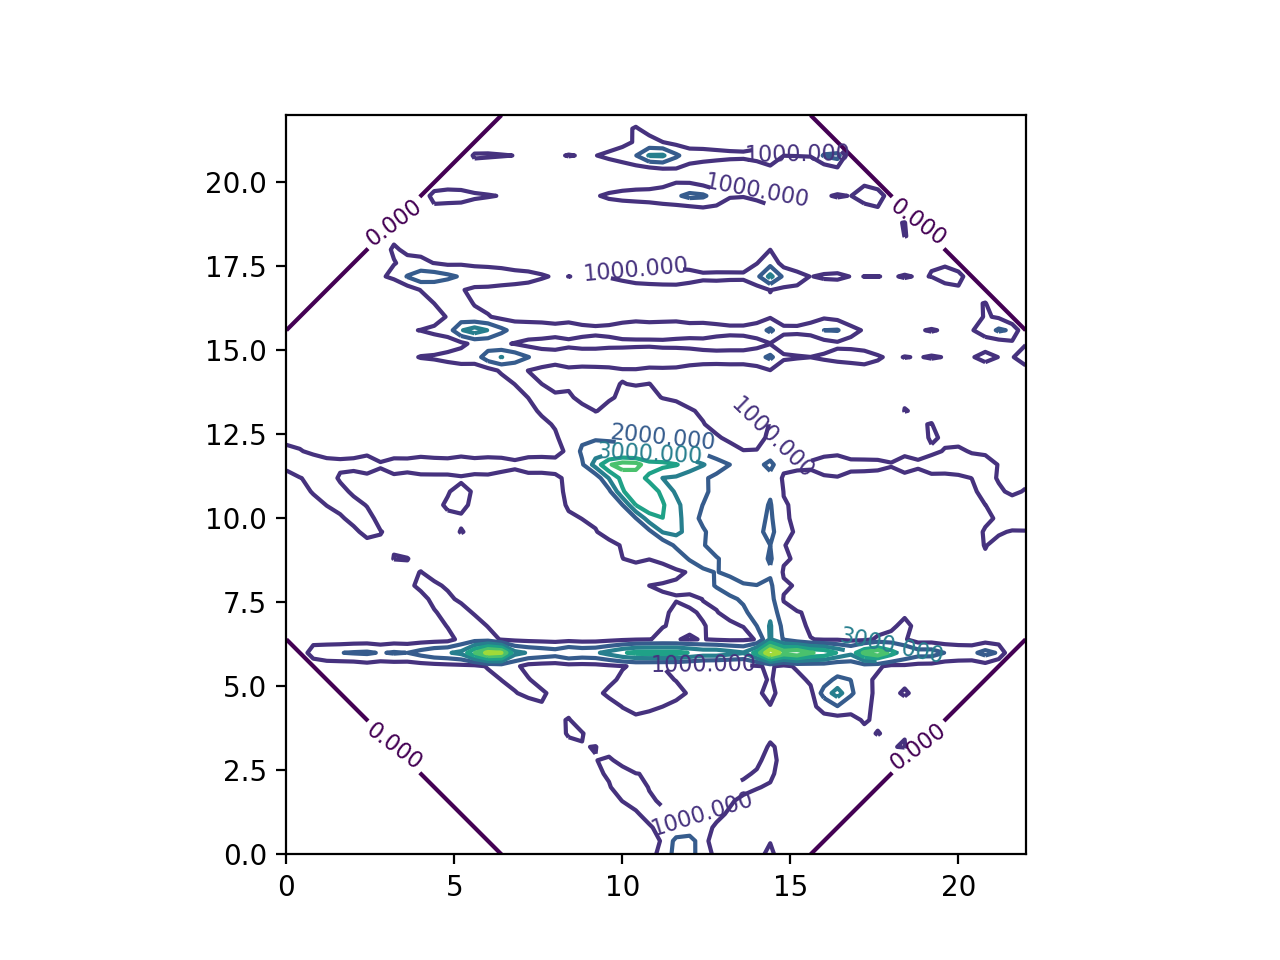

In [9]:
fig, ax = plt.subplots()

x = np.linspace(0,22,len(normalized)) 
y = np.linspace(0,22,len(normalized))
X, Y = np.meshgrid(x, y) # These set up a coordinate system for the contour plot

num_lines = 6
flipped = normalized[::-1] # This is Python sorcery that flips the data vertically so that it matches the other plots.

p = ax.contour(X, Y, flipped,num_lines)
ax.clabel(p, inline=True, fontsize=8) # This adds numbers to contours
ax.set_aspect('equal')

Another useful option is to make a fully 3d projection

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0,22,len(normalized)) 
y = np.linspace(0,22,len(normalized))
X, Y = np.meshgrid(x, y) # These set up a coordinate system for the contour plot

ax.plot_surface(X, Y, flipped,cmap='plasma') #color maps are not required
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('coincidence intensity')
ax.set_title('3D Projection Example');

We can also do this for each of our slices, giving a 3d view of how our reconstruction step-by-step.

In [ ]:
composite = np.ones_like(rotated_data[0]) 
for index, item in enumerate(rotated_data):
    fig = plt.figure()
    ax = fig.add_subplot(211, projection='3d')
    ay = fig.add_subplot(212, projection='3d')
    
    x = np.linspace(0,22,len(item)) 
    y = np.linspace(0,22,len(item))
    X, Y = np.meshgrid(x, y) # These set up a coordinate system for the contour plot
    
    ax.plot_surface(X, Y, item,cmap='plasma') #color maps are not required
    composite *= item   
    ay.plot_surface(X, Y, np.power(composite,(1/(index+1))),cmap='plasma') #color maps are not required
    
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('y (cm)')
    ax.set_zlabel('coincidence intensity')
    ax.set_title('3D Projection Example')
    
    ay.set_xlabel('x (cm)')
    ay.set_ylabel('y (cm)')
    ay.set_zlabel('coincidence intensity')
    ay.set_title('3D Reconstruction')

# Advanced Techniques
----
We can do a few things to improve our reconstruction technique here.  To start, let's see if we can do something about the jaggedness of the rotations.  We can do this by repeating values in the slices multiple times, so there's more space for interpolation.

There are any number of ways to accomplish this, and probably some better than this, but this will get the job done.

In [ ]:
expansion_value = 2
expanded_slice = [np.array([])]
for index,slices in enumerate(data):
    for element in slices:  # This goes through each slice one item at a time
        repeat_values = np.full(expansion_value,element) # makex an x by 1 array full of one value
        expanded_slice[index] = np.append(expanded_slice[index], repeat_values) # This tacks on the expanded bit on the end of our array
    expanded_slice.append(np.array([])) # This adds a new empty array to the end of things
expanded_slice.pop()    #We accidentally create an extra empty array, so this gets rid of it
print(data[0])
print(expanded_slice[0])

The expanded_slice here is just the same values, but doubled up in the array.  Now we'll do our matrix expansion and rotation, and see what the difference is.

In [ ]:
expand_vec = np.ones(expanded_slice[0].size)
expanded_rotation = []
for index, item in enumerate(expanded_slice):
    expanded_rotation.append(ndimage.rotate(np.outer(expand_vec,item),angles[index],reshape=False))

expanded_composite = np.ones_like(expanded_rotation[0])
for item in expanded_rotation:
    expanded_composite *= item
expanded_normalized = np.power(expanded_composite,(1/len(data)))

fig, (ax,ay) = plt.subplots(2)
ax.imshow(normalized)
ax.set_title("Multiplication combination: No smoothing")    
ay.imshow(expanded_normalized)
ay.set_title("Multiplication combination: 2x smoothing")
fig.tight_layout()

This does a lot to get rid of some of the jaggedness of the reconstruction, but there are also likely some shadows caused by us having multiple sources here.

We can also use a professional reconstruction technique: a [radon transform](https://en.wikipedia.org/wiki/Radon_transform).  At heart this technique uses a Fourier transform of slices, recombines these in a polar format, and then does an inverse Fourier transform.  You can try and work this out for yourself, but we can also use a package from `skimage` to do this for us with our data.  Since we're starting with slice/angle data, we'll be doing an inverse transformation.

You'll need to install the package in Anaconda for this to work.

In [ ]:
from skimage.transform import iradon
reconstruction = iradon(np.transpose(np.array(data)),theta=np.array(angles)) 
# the transpose makes it line up with our other method

In [ ]:
fig, ax = plt.subplots()
ax.imshow(reconstruction)
ax.set_title("Inverse radon transform data");

As expected the results are similar, but there are some differences in the intensities.